<a href="https://colab.research.google.com/github/duyqu-chan/Reinforcement-Learning/blob/master/Optimal_Path_Finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Shortest Path with Q-Learning

Duygu Can
---
Starting from node 0,  we need to find the shortest path to node 10 in the undirected graph shown below, with *Q-Learning* algorithm. 

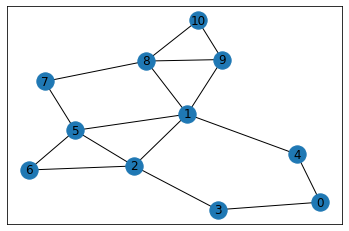

In [54]:
import networkx as nx
import pylab as pl
edges = [(0, 4), (4, 0), (0, 3), (3, 0), (1, 2), (2, 1),
         (1, 4), (4, 1), (1, 8), (8, 1), (1, 9), (9, 1),
         (2, 3), (3, 2), (2, 6), (6, 2), (1, 5), (5, 1),
         (2, 5), (5, 2), (5, 6), (6, 5), (7, 8), (8, 7),
         (7, 5), (5, 7), (8, 9), (9, 8), (8, 10), (10, 8),
         (9, 10), (10, 9)]

G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
pl.show()

The *networkx* library randomly generates this graph. We will define $n_i$ as $i^{th}$ node of the graph for $i = 0, 1, ..., 10$ and $r(n_i,n_j)$ is the reward gained during transition from state $n_i$ to $n_j$. In general, the reward of allowable actions are set to zero except when entering the goal state ($n_{10}$). However, unallowed transitions should also be punished (i.e. negative reward). 

\begin{equation*}
r(n_i, n_j) = \left\{
\begin{array}{rl}
-100 & \text{if } n_i \text{ & } n_j \text{ are not connected} ,\\
+100 & \text{if } j = 10 \text{ (goal)}\\
0 & \text{otherwise}.
\end{array} \right.
\end{equation*}

Using this case defined function for reward, lets form a reward matrix.




In [71]:
import numpy as np
N = 11 #size of reward matrix
R = np.matrix(np.ones(shape =(N, N))) #initialize an NxN matrix for reward 
R *= -100 #set all entries to -100 (assuming unallowed transition)
  
for node in edges: #loop over nodes
    #print(node) 
    if node[1] == 10:    #if the transition of interest leads to the goal state,
        R[node] = 100    #give a reward.
    else:                #if not,
        R[node] = 0      #no reward.

R[10, 10]= 100 #the closed loop from goal to goal is rewarded to force staying there
print(R) 

[[-100. -100. -100.    0.    0. -100. -100. -100. -100. -100. -100.]
 [-100. -100.    0. -100.    0.    0. -100. -100.    0.    0. -100.]
 [-100.    0. -100.    0. -100.    0.    0. -100. -100. -100. -100.]
 [   0. -100.    0. -100. -100. -100. -100. -100. -100. -100. -100.]
 [   0.    0. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100.    0.    0. -100. -100. -100.    0.    0. -100. -100. -100.]
 [-100. -100.    0. -100. -100.    0. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100.    0. -100. -100.    0. -100. -100.]
 [-100.    0. -100. -100. -100. -100. -100.    0. -100.    0.  100.]
 [-100.    0. -100. -100. -100. -100. -100. -100.    0. -100.  100.]
 [-100. -100. -100. -100. -100. -100. -100. -100.    0.    0.  100.]]


For each state and action we need to initialize Q-estimates to zero (i.e. $\hat{Q}(s,a) = 0$). Notice that in this study I am using state and node interchangebly. Let us also define the discount factor, $\gamma$, as $0.8$.

In [56]:
Q = np.matrix(np.zeros([N, N]))
gamma = 0.8
print(Q)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Our initial state is $0^{th}$ node. Below we see rewards gained from each transition rooting from the initial state.

In [57]:
R[0,]

matrix([[-100., -100., -100.,    0.,    0., -100., -100., -100., -100.,
         -100., -100.]])

However, not all actions are allowed. Remember that there is no transition between unconnected nodes, so such actions are rewarded negatively (i.e with -100). So, available actions are non-zero ones. As it is seen from the graph above 0th node is connected to 3rd and 4th nodes.

In [58]:
np.where(R[0,] >= 0)[1]

array([3, 4])

The function below generalizes this to any node given.

In [59]:
def possible_transitions(node): 
    ''' Finds available actions that can be taken in a state.'''

    rewards_for_state = R[node, ] # find the row related to the given state

    #chose final states of the actions with nonzero reward values
    possible_transition = np.where(rewards_for_state >= 0)[1]

    return possible_transition
#test
print(possible_transitions(0)) 

[3 4]


Let's choose a random action from the possible transitions. The number printed below will be index of the one of the nodes that can be taken from the 0th node.

In [60]:
int(np.random.choice(possible_transitions(0), 1)) 

4

Similarly it can be generalized to other nodes, as below.

In [61]:
def next_state(possible_transitions_range): 
    ''' Random sampling of available actions'''

    next = int(np.random.choice(possible_transitions_range, 1)) 
    return next

#test
node = 0
actions_available = possible_transitions(node)
next_node = next_state(actions_available)
print(next_node)

3


Let's update Q-estimates for a randomly chosen path.

In [66]:
def update(current_node, action, gamma): 
    ''' This function updates'''
    #index of
    max_index = np.where(Q[action, ] == np.max(Q[action, ]))[1] 
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1)) 
    else:
        max_index = int(max_index) 
    
    max_value = Q[action, max_index]
    Q[current_node, action] = R[current_node, action] + gamma * max_value
    if (np.max(Q) > 0):
        return(np.sum(Q / np.max(Q)*100)) 
    else:
        return (0) 
# Updates the Q-Matrix according to the path chosen 
  
update(0, next_node, gamma) 

0

Most efficient path:
[0, 4, 1, 8, 10]


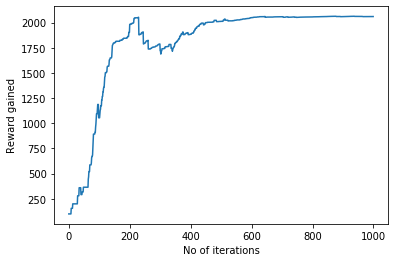

In [70]:
scores = [] 
for i in range(1000): 
    current_state = np.random.randint(0, int(Q.shape[0])) 
    available_action =possible_transitions(current_state) 
    action = next_state(available_action) 
    score = update(current_state, action, gamma) 
    scores.append(score) 
  
# print("Trained Q matrix:") 
# print(Q / np.max(Q)*100) 
# You can uncomment the above two lines to view the trained Q matrix 
  
# Testing 
current_state = 0
steps = [current_state] 
  
while current_state != 10: 
  
    next_step_index = np.where(Q[current_state, ] == np.max(Q[current_state, ]))[1] 
    if next_step_index.shape[0] > 1: 
        next_step_index = int(np.random.choice(next_step_index, size = 1)) 
    else: 
        next_step_index = int(next_step_index) 
    steps.append(next_step_index) 
    current_state = next_step_index 
  
print("Most efficient path:") 
print(steps) 
  
pl.plot(scores) 
pl.xlabel('No of iterations') 
pl.ylabel('Reward gained') 
pl.show() 

## References

1. [Intro to Reinforcement Learning: Q-Learning 101](https://medium.com/analytics-vidhya/intro-to-reinforcement-learning-q-learning-101-8df55fed9be0)
2. [Understanding Q-Learning, the Cliff Walking problem](https://medium.com/@lgvaz/understanding-q-learning-the-cliff-walking-problem-80198921abbc)
3. [An introduction to Q-Learning: reinforcement learning](https://www.freecodecamp.org/news/an-introduction-to-q-learning-reinforcement-learning-14ac0b4493cc/)
4. Machine Learning, Tom Mitchell, McGraw Hill, 1997.
5. [ML | Reinforcement Learning Algorithm : Python Implementation using Q-learning](https://www.geeksforgeeks.org/ml-reinforcement-learning-algorithm-python-implementation-using-q-learning/)